# Neuron Layers

> Turning Lagrangians into building blocks for our network

Fundamentally, a neuron layer is nothing more than a lagrangian function on top of data. This Lagrangian completely defines both an **energy** and an **activation** for the layer. In practice, we additionally specify the following in addition to the Lagrangian:

- A `shape`
- A time constant `tau`
- A `bias` (optional) that we can view as the activation threshold of a neuron layer

Our neuron layers are extensions of the neuron layer as it is commonly incorporated in feedforward architectures. The primary difference is that our neuron layers *evolve their state $x$ over time* and have a *bounded energy function* on their states. The energy function of our neuron is completely defined by its Lagrangian $\mathcal{L}$

$$E_\text{layer} = \sum\limits_i x_i g_i - \mathcal{L}(x)$$

where $g = \frac{\partial \mathcal{L}}{\partial x}$ is also called the "activations". The first component is a summation of the elementwise multiplication between $x$ and $g$. The second term is the Lagrangian. This energy function is the direct consequence of the Legendre transform on the Lagrangian.

We can view a neuron layer of shape `(D,)` as a collection of $D$ neurons holding scalar data. Convolutional networks frequently have activations defined atop images or image patches of shape `(D,H,W)`. We can view layers of this shape as a collection of $D$ neurons each of shape $(H,W)$. Lagrangians that reduce over a particular dimension (e.g., the `softmax`) will always reduce over the neuron dimension $D$.

In [ ]:
#| default_exp layers

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

In [ ]:
#| hide
warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
#| export
import jax
import jax.numpy as jnp
from typing import *
import treex as tx
from abc import ABC, abstractmethod
from flax import linen as nn
from hamux.lagrangians import *
import functools as ft
from fastcore.meta import delegates
from fastcore.utils import *
from fastcore.basics import *

In [ ]:
#| export
class Layer(tx.Module):
    """The energy building block of any activation in our network that we want to hold state over time"""
    lagrangian: tx.Module 
    shape: Tuple
    tau: float
    use_bias: bool
    bias: jnp.ndarray = tx.Parameter.node(default=None)

    def __init__(self, 
                 lagrangian:tx.Module, # Factory function creating lagrangian module describing
                 # lagrangian:Union[Callable, tx.Module], Either a factory function or the module itself depending on `init_lagr's` value
                 shape:Tuple[int], # Number and shape of neuron assembly
                 tau:float=1.0, # Time constant
                 use_bias:bool=False, # Add bias?
                 init_lagrangian=False, # Initialize the lagrangian with kwargs?
                 name:str=None, # Overwrite default class name, if provided
                 **kwargs, # Passed to lagranigan factory
                ): 
        self.lagrangian = lagrangian(**kwargs) if init_lagrangian else lagrangian
        self.shape = shape
        assert tau > 0.0, "Tau must be positive and non-zero"
        self.tau = tau
        self.use_bias = use_bias

        if name is not None:
            self.name = name
        
    def energy(self, x):
        """The predefined energy of a layer, defined for any lagrangian"""
        if self.initializing():
            if self.use_bias:
                self.bias = nn.initializers.normal(0.02)(tx.next_key(), self.shape)
        x2 = x - self.bias if self.use_bias else x # Is this an issue?

        # When jitted, this is no slower than the optimized `@` vector multiplication
        return jnp.multiply(self.g(x), x2).sum() - self.lagrangian(x2)
        
    def __call__(self, x):
        """Alias for `self.energy`. Helps simplify treex's `.init` method"""
        return self.energy(x)
            
    def activation(self, x):
        """The derivative of the lagrangian is our activation or Gain function `g`. 
        
        Defined to operate over input states `x` of shape `self.shape`
        """
        if self.initializing():
            if self.use_bias:
                self.bias = nn.initializers.normal(0.02)(tx.next_key(), self.shape)
        x2 = x - self.bias if self.use_bias else x
        return jax.grad(self.lagrangian)(x2)
    
    def g(self, x):
        """Alias for `self.activation`"""
        return self.activation(x)

    def init_state(self, 
                   bs: int = None, # Batch size
                   rng=None): # If given, initialize states from a normal distribution with this key
        """Initialize the states of this layer, with correct shape.
        
        If `bs` is provided, return tensor of shape (bs, *self.shape), otherwise return self.shape
        By default, initialize layer state to all 0.
        """
        layer_shape = self.shape if bs is None else (bs, *self.shape)
        if rng is not None:
            return jax.random.normal(rng, layer_shape)
        return jnp.zeros(layer_shape)

Initialize with a lagrangian

In [ ]:
Layer(LExp(beta=5.), (32,32,3))

Layer {
    bias: None,
    lagrangian: LExp {
        beta: 5.0,          Parameter
        min_beta: 1e-06,
        name: "lexp",       str
    },
    name: "layer",          str
    shape: tuple [
        32,
        32,
        3,
    ],
    tau: 1.0,
    use_bias: False,
}

In [ ]:
show_doc(Layer.energy)

---

[source](https://github.com/bhoov/hamux/blob/main/hamux/layers.py#L48){target="_blank" style="float:right; font-size:smaller"}

### Layer.energy

>      Layer.energy (x)

The predefined energy of a layer, defined for any lagrangian

In [ ]:
show_doc(Layer.__call__)

---

[source](https://github.com/bhoov/hamux/blob/main/hamux/layers.py#L58){target="_blank" style="float:right; font-size:smaller"}

### Layer.__call__

>      Layer.__call__ (x)

Alias for `self.energy`. Helps simplify treex's `.init` method

In [ ]:
show_doc(Layer.activation)

---

[source](https://github.com/bhoov/hamux/blob/main/hamux/layers.py#L62){target="_blank" style="float:right; font-size:smaller"}

### Layer.activation

>      Layer.activation (x)

The derivative of the lagrangian is our activation or Gain function `g`. 

Defined to operate over input states `x` of shape `self.shape`

In [ ]:
show_doc(Layer.g)

---

[source](https://github.com/bhoov/hamux/blob/main/hamux/layers.py#L73){target="_blank" style="float:right; font-size:smaller"}

### Layer.g

>      Layer.g (x)

Alias for `self.activation`

In [ ]:
show_doc(Layer.init_state)

---

[source](https://github.com/bhoov/hamux/blob/main/hamux/layers.py#L77){target="_blank" style="float:right; font-size:smaller"}

### Layer.init_state

>      Layer.init_state (bs:int=None, rng=None)

Initialize the states of this layer, with correct shape.

If `bs` is provided, return tensor of shape (bs, *self.shape), otherwise return self.shape
By default, initialize layer state to all 0.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| bs | int | None | Batch size |
| rng | NoneType | None | If given, initialize states from a normal distribution with this key |

## Convenience Layers

It is nice to package commonly used lagrangians into their own kind of layers, e.g., `IdentityLayer`s or `SoftmaxLayer`s. We create a helper function to do that in this section.

In [ ]:
#| export
def MakeLayer(lagrangian_factory:Callable, 
              name:Optional[str]=None): # Name of the new class
    """Hack to make it easy to create new layers from `Layer` utility class.
    
    `delegates` modifies the signature for all Layers. We want a different signature for each type of layer.

    So we redefine a local version of layer and delegate that for type inference.
    """
    global Layer

    @delegates(lagrangian_factory, keep=True)
    class Layer(Layer):
        __doc__ = Layer.__doc__
        
    out = partialler(Layer, lagrangian_factory, init_lagrangian=True, name=name)
    out.__doc__ = Layer.__doc__

    return out

In [ ]:
#| export

# Some reason, docstrings are not showing the new kwargs, and the docs for these are broken. 
IdentityLayer = MakeLayer(LIdentity, "identity_layer")
RepuLayer = MakeLayer(LRepu, "repu_layer")
ReluLayer = MakeLayer(LRelu, "relu_layer")
SoftmaxLayer = MakeLayer(LSoftmax, "softmax_layer")
SigmoidLayer = MakeLayer(LSigmoid, "sigmoid_layer")
TanhLayer = MakeLayer(LTanh, "tanh_layer")
ExpLayer = MakeLayer(LExp, "exp_layer")
RexpLayer = MakeLayer(LRexp, "rexp_layer")
LayerNormLayer = MakeLayer(LLayerNorm, "layernorm_layer")

In [ ]:
# show_doc(SigmoidLayer)

Our utility that we use to create these "convenience layers" is a bit hacky, but it works by injecting the lagrangian and the expected arguments for the lagrangian into our `Layer` utility:

In [ ]:
# show_doc(MakeLayer)

By doing this hack, we lose the ability to inspect docstrings.

## Energy Analysis

Most of all, every neuron layer has an **energy**. This is defined by the following equation:

$$E_\text{layer} = \sum\limits_i x_i g_i - \mathcal{L}(x)$$

The first component is a summation of the elementwise multiplication between $x$ and $g$. The second term is the lagrangian.

Let us create a layer with state $x$ and initial state $x_0$. Let us then evolve $x$ over time by simply descending the energy of the neuron layer. Note that this neuron layer is not connected to anything, but we still expect it to reach a fixed point where the energy of the layer reaches a fixed point.

$$\tau\frac{dx}{dt} = -\frac{dE_\text{layer}}{dx}$$

2022-10-13 12:46:38.261018: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


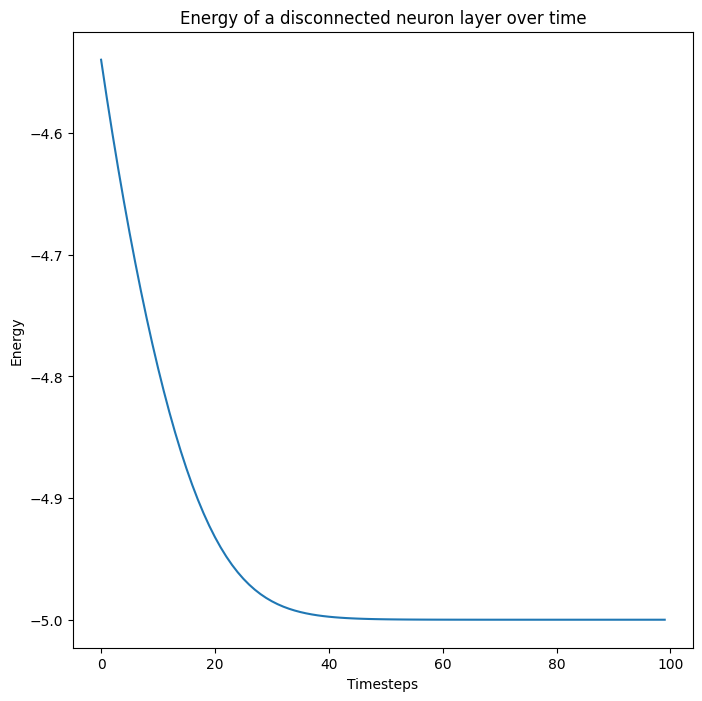

In [ ]:
#| code-fold: true
shape = (5,); key = jax.random.PRNGKey(0); k1, k2, key = jax.random.split(key,3)
layer = ExpLayer(shape,beta=1.).init(k1, jnp.ones(shape))
x0 = layer.init_state(rng=k2)

@ft.partial(jax.jit, static_argnames=("alpha",))
def next_x(layer:Layer, # Neuron layer
           x:jnp.ndarray, # Current state
           alpha:float): # Step size
    dEdx = jax.value_and_grad(layer.energy)
    E, dx = dEdx(x)
    next_x = x -alpha * dx
    return E, next_x

x = x0
Es = []
for i in range(100):
    E, x = next_x(layer, x, 0.1)
    Es.append(E)
    
fig, ax = plt.subplots(1)
ax.plot(np.stack(Es))
ax.set_title("Energy of a disconnected neuron layer over time")
ax.set_ylabel("Energy")
ax.set_xlabel("Timesteps")
plt.show(fig)

The energy is bounded for any initial neuron state $x$ (though at some point the values are numerically too large for the exponential we are using as the activation function)

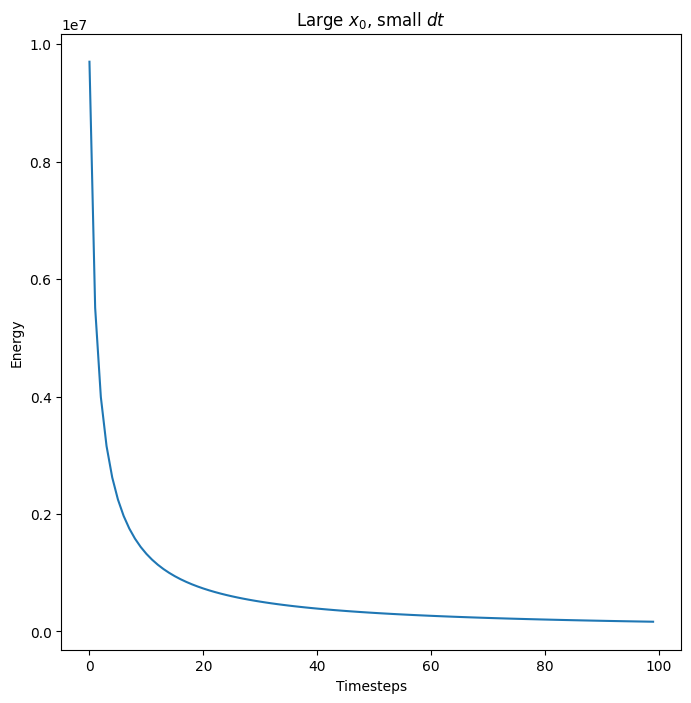

In [ ]:
#| code-fold: true
x = 100*x0
Es = []
for i in range(100):
    E, x = next_x(layer, x, 5e-8)
    Es.append(E)
    
fig, ax = plt.subplots(1)
ax.plot(np.stack(Es))
ax.set_title("Large $x_0$, small $dt$")
ax.set_ylabel("Energy")
ax.set_xlabel("Timesteps")
plt.show(fig)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()